In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from keras.models import model_from_json

import pyqtgraph as pg
from pyqtgraph import QtGui
import pyqtgraph.opengl as gl

In [2]:
def gen_surface_normal(depth_image):
    d_im = depth_image
    
    zy, zx = np.gradient(d_im)  

    normal = np.dstack((-zx, -zy, np.ones_like(d_im)))
    n = np.linalg.norm(normal, axis=2)
    normal[:, :, 0] /= n
    normal[:, :, 1] /= n
    normal[:, :, 2] /= n

    normal += 1
    normal /= 2
    normal *= 255

    return normal[:, :, ::-1].astype(int)


### Load Saved model

In [6]:
json_file = open(os.path.join('Model and Weights', 'model.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.summary()
model.load_weights(os.path.join('Model and Weights', 'ModelWeights.hdf5'))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 126, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 60, 80, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 60, 80, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

### Sample Output

Text(0.5, 1.0, 'Surface Normal')

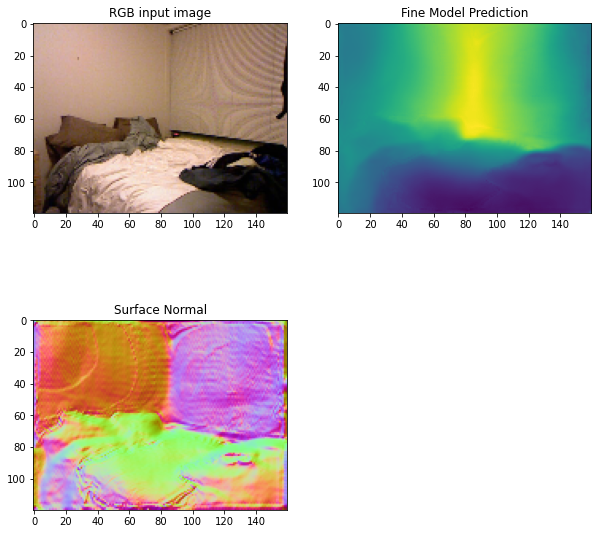

In [8]:
img = cv2.imread('Test_Image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img/255.

preds = model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))

prediction = preds[0,:,:]

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

ax1.imshow(img)
ax1.set_title('RGB input image')

ax2.imshow(prediction)
ax2.set_title('Fine Model Prediction')

ax3.imshow(gen_surface_normal(prediction[:,:,0]*255))
ax3.set_title('Surface Normal')


### Visualise in 3D

In [10]:
x = np.arange(0,160,1)
y = np.arange(0,120,1)

X, Y = np.meshgrid(x, y)

depth_img = prediction*255
Z = depth_img.flatten().reshape(120,160)

pos = np.empty((120*160, 3))
pos[:,0] = X.flatten()
pos[:,1] = Y.flatten()
pos[:,2] = Z.flatten()

color = np.empty(((120*160), 4))

color[:,0] = img[:,:,0].flatten()
color[:,1] = img[:,:,1].flatten()
color[:,2] = img[:,:,2].flatten()
color[:,3] = 1

In [11]:
pg.mkQApp()

view = gl.GLViewWidget()
view.setBackgroundColor([51,51,102])
view.resize(500,500)
view.show()


pos[:,0] *= -1
pos[:,1] *= -1
color[:,-1] = 255

sp1 = gl.GLScatterPlotItem(pos=pos, size=5, color=color, pxMode=True)
sp1.setGLOptions('translucent')
sp1.translate(-pos[0,0],-pos[0,1],-pos[0,2])
view.addItem(sp1)

QtGui.QApplication.instance().exec_()

Unable to load numpy_formathandler accelerator from OpenGL_accelerate


0